### 1- Préparation des données

In [14]:
import pandas as pd
data = pd.read_csv('donnees_nettoyees.csv', sep=";")
print(type(data))

#print(data.head(5))
data.info

<class 'pandas.core.frame.DataFrame'>


<bound method DataFrame.info of                 X            Y  OBJECTID     src_geo  \
0     1720320.108  8294619.356         1  Orthophoto   
1     1720898.301  8293531.134         2  Orthophoto   
2     1720893.840  8293542.450         3  Orthophoto   
3     1720901.650  8293545.467         4  Orthophoto   
4     1721089.065  8293619.339         5  Orthophoto   
...           ...          ...       ...         ...   
9025  1721738.392  8295825.625     12030  Orthophoto   
9026  1718512.660  8293671.382     12033  Orthophoto   
9027  1721676.588  8295878.677     12035  Orthophoto   
9028  1721704.512  8295829.743     12036  Orthophoto   
9029  1721757.045  8295872.979     12037  Orthophoto   

                  clc_quartier              clc_secteur  haut_tot  haut_tronc  \
0     Quartier du Centre-Ville      Boulevard Richelieu       0.0         0.0   
1     Quartier du Centre-Ville      Boulevard Leon Blum       0.0         0.0   
2     Quartier du Centre-Ville      Boulevard Leon B

### 2- Apprentissage supervisé pour la régression

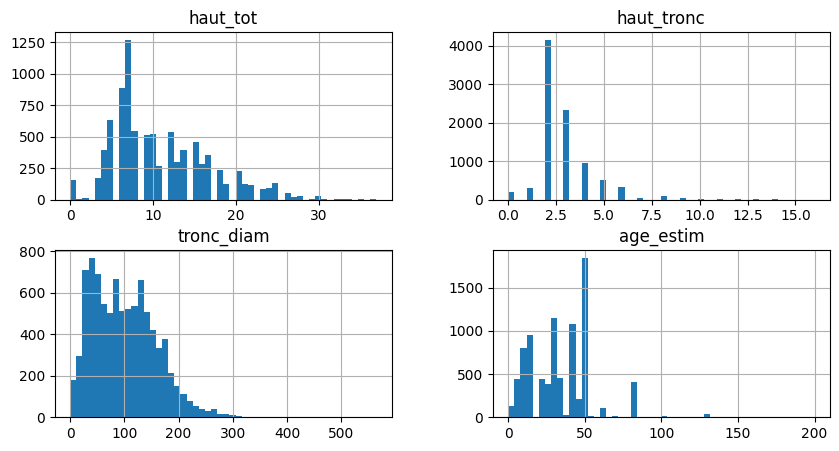

In [15]:
#data.value_counts("haut_tot")
data.describe()

import matplotlib.pyplot as plt
data[["haut_tot", "haut_tronc", "tronc_diam", "age_estim"]].hist(bins=50, figsize=(10,5))
plt.show()


Répartition des données

In [22]:
# Base de données de près de 10 000 lignes, on a choisi une répartirion 80/20.
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(data, test_size=0.2, random_state=42)

#train_set.head()
print(len(train_set))
print("\n")
#test_set.head()
print(len(test_set))

7224


1806


Il va falloir qu'on netoie un peu les informations qu'on a à disposition et qu'on sépare les features de la valeur cible. Le chi2 avait de plus fonctionné avec pas mal de valeurs qualitatives qu'il va falloir passer en numérique afin que la phase d'apprentissage soit plus simple pour le programme.

In [24]:
#séparation des features et de la valeur cible
train_data = train_set.drop("age_estim", axis=1) #drop labels for training set
#print(train_data)
train_labels = train_set["age_estim"].copy()
print(train_labels)

4477    30.0
2766    40.0
2484    50.0
5244    40.0
4801    30.0
        ... 
5734    30.0
5191    35.0
5390     5.0
860     50.0
7270    15.0
Name: age_estim, Length: 7224, dtype: float64


In [29]:
#remplacement des valeurs non remplies pour l'âge
median_age = train_labels.median()
print("valeur de la médiane : " + str(median_age))
train_labels.fillna(median_age, inplace=True)
print(train_labels.info())

valeur de la médiane : 30.0
<class 'pandas.core.series.Series'>
Index: 7224 entries, 4477 to 7270
Series name: age_estim
Non-Null Count  Dtype  
--------------  -----  
7224 non-null   float64
dtypes: float64(1)
memory usage: 112.9 KB
None


In [45]:
from sklearn.preprocessing import OrdinalEncoder

# Initialiser l'OrdinalEncoder
encoder = OrdinalEncoder()

# Appliquer l'encodeur aux colonnes sélectionnées
train_data[["clc_quartier", "clc_secteur", "fk_port", "fk_pied", "fk_situation"]] = encoder.fit_transform(train_data[["clc_quartier", "clc_secteur", "fk_port", "fk_pied", "fk_situation"]])

# Afficher les premières valeurs des colonnes encodées
#train_data[["clc_quartier", "clc_secteur", "fk_port", "fk_pied", "fk_situation"]].head(10)

train_data = train_data[["clc_quartier", "clc_secteur", "haut_tot", "haut_tronc", "tronc_diam", "fk_port", "fk_pied", "fk_situation"]]
#train_data.head(10)

# Nettoyage restant pour les colones d'entrée
cols_to_fill = ["clc_quartier", "clc_secteur", "haut_tot", "haut_tronc", "tronc_diam", "fk_port", "fk_pied", "fk_situation"]

for col in cols_to_fill:
    median_value = train_data[col].median()
    print("median" + str(col) + " " + str(median_value))
    train_data[col].fillna(median_value, inplace=True)

#print(train_data.info())



medianclc_quartier 5.0
medianclc_secteur 147.0
medianhaut_tot 9.0
medianhaut_tronc 2.0
mediantronc_diam 95.0
medianfk_port 12.0
medianfk_pied 6.0
medianfk_situation 0.0


C:\Users\CHAUVEAU Maxime\AppData\Local\Temp\ipykernel_3824\3803517496.py:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_data[col].fillna(median_value, inplace=True)
C:\Users\CHAUVEAU Maxime\AppData\Local\Temp\ipykernel_3824\3803517496.py:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behav

Apprentissage du modèle de régression linéaire : 

In [48]:
from sklearn.linear_model import LinearRegression
#train_data.head(10)
#train_labels.head(10)
reg = LinearRegression()
reg.fit(train_data, train_labels)

LinearRegression()

In [ ]:
#évaluation du modèle d'apprentissage
reg.predict(train_data)
print("predictions : " + str(reg.predict(train_data)))
print("labels : " + str(train_labels))


predictions : [21.94545296 23.72633471 36.10104301 ... 20.72047128 54.48621465
 22.49768194]
labels : 4477    30.0
2766    40.0
2484    50.0
5244    40.0
4801    30.0
        ... 
5734    30.0
5191    35.0
5390     5.0
860     50.0
7270    15.0
Name: age_estim, Length: 7224, dtype: float64


In [52]:
#RMSE
from numpy import sqrt
from sklearn.metrics import mean_squared_error
RMSE = sqrt(mean_squared_error(train_labels, reg.predict(train_data)))
print(RMSE)

11.54732549998008


In [53]:
#utilisation du decisionTreeRegressor
from sklearn.tree import DecisionTreeRegressor
DecisionTreeRegressor = DecisionTreeRegressor()
DecisionTreeRegressor.fit(train_data, train_labels)

DecisionTreeRegressor()

In [54]:
#RMSE sur DecisionTreeRegressor : 
RMSE = sqrt(mean_squared_error(train_labels, DecisionTreeRegressor.predict(train_data)))
print(RMSE)

0.6981343460632725


In [56]:
# Créer un DataFrame avec les valeurs réelles et prédites
comparison_df = pd.DataFrame({'Réalité': train_labels, 'Prédiction': predictions})

# Afficher les 10 premières lignes du tableau
print(comparison_df.head(10))

      Réalité  Prédiction
4477     30.0        30.0
2766     40.0        40.0
2484     50.0        50.0
5244     40.0        40.0
4801     30.0        30.0
970      40.0        40.0
4574     30.0        30.0
4667     15.0        15.0
6758     30.0        30.0
7264     15.0        15.0


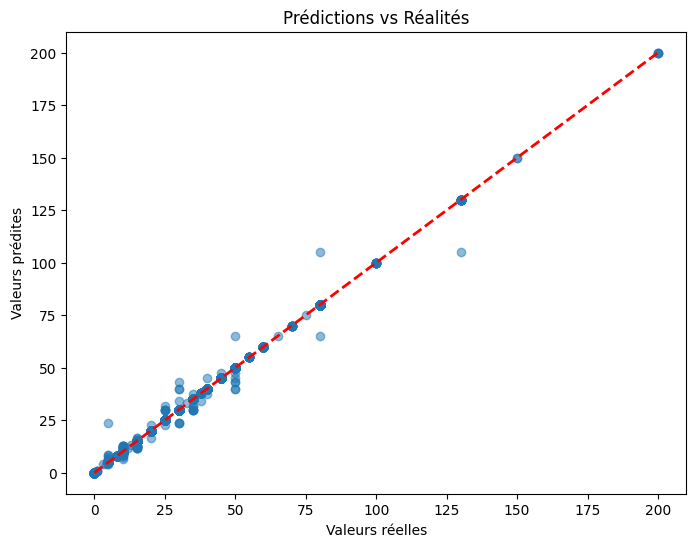

In [55]:
import matplotlib.pyplot as plt

# Prédictions du modèle
predictions = DecisionTreeRegressor.predict(train_data)

# Création du graphique de dispersion
plt.figure(figsize=(8,6))
plt.scatter(train_labels, predictions, alpha=0.5)  # alpha pour la transparence des points
plt.plot([train_labels.min(), train_labels.max()], [train_labels.min(), train_labels.max()], 'r--', lw=2)  # ligne y=x pour la référence
plt.xlabel('Valeurs réelles')
plt.ylabel('Valeurs prédites')
plt.title('Prédictions vs Réalités')
plt.show()

In [58]:
#test : 

from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
import numpy as np

# Définir le modèle de régression (DecisionTreeRegressor)
model = DecisionTreeRegressor()
model2 = LinearRegression()

# Appliquer la validation croisée avec 10 folds, en utilisant l'argument "neg_mean_squared_error"
scores = cross_val_score(model, train_data, train_labels, cv=10, scoring="neg_mean_squared_error")
scores2 = cross_val_score(model2, train_data, train_labels, cv=10, scoring="neg_mean_squared_error")

# Convertir les scores (MSE négatifs) en RMSE (en prenant la racine carrée et en multipliant par -1)
rmse_scores = np.sqrt(-scores)
rmse_scores2 = np.sqrt(-scores2)

# a. Afficher les RMSE de chaque fold
print("RMSE de chaque fold :")
print(rmse_scores)
print(rmse_scores2)

# b. Afficher la moyenne des RMSE
mean_rmse = np.mean(rmse_scores)
mean_rmse2 = np.mean(rmse_scores2)
print("\nMoyenne des RMSE :")
print(mean_rmse)
print(mean_rmse2)


RMSE de chaque fold :
[ 9.09974313  8.04385886  8.98966972  7.43137111  8.56992179  8.72097536
  7.8682817   7.86748586 12.36862169  7.82883065]
[11.32426911 11.2679595  11.65183338 11.58064584 12.3150634  11.62949076
 11.75704195 11.47774391 11.64715047 10.98208706]

Moyenne des RMSE :
8.67887598758302
11.563328538006854


In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt

test_data = test_set.drop("age_estim", axis=1) #drop labels for training set
#print(train_data)
train_labels = test_set["age_estim"].copy()


# TODO ! Tout le nettoyage de la partie de test

print(train_labels)
# Prédiction sur le jeu de test TODO ! 
test_predictions = reg.predict(test_data)

# Calcul du RMSE sur les données de test
test_rmse = sqrt(mean_squared_error(test_labels, test_predictions))
print("RMSE sur le jeu de test :", test_rmse)

### 3- Métriques pour la régression

### 4- Préparation script python